In [11]:
%matplotlib inline
import matplotlib
import string
import numpy as np
import pandas as pd
from gensim import summarization
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import sentiwordnet as swn
from bs4 import BeautifulSoup
from classifiers.LexiconClassifier import LexiconSentimentAnalyzer

# Preprocessing data

In [16]:
PUNCTUATIONS = set(string.punctuation)

def remove_html(text):
    try:
        soup = BeautifulSoup(text,"html.parser")
    except Exception:
        return text
    else:
        return soup.get_text()

def have_common_words(summary,review):
    tokens_summ = word_tokenize(summary.lower())
    tokens_rev = word_tokenize(review.lower())
    if set(tokens_summ).issubset(set(tokens_rev)):
        return 1
    return 0

def remove_punct(text):
    return ''.join(ch for ch in text if ch not in PUNCTUATIONS)

## Reviews containing summary

In [ ]:

data = pd.read_csv('dataset/Reviews.csv',header=0,index_col=0,nrows=10000,usecols=['Id','Summary','Text'],encoding='utf-8')
data.dropna(how='any',inplace=True)
data.Summary = data.Summary.map(remove_html)
data.Text = data.Text.map(remove_html)

drop_indices = []
for index,row in data.iterrows():
    if index%1000 == 0:
        print index
    if have_common_words(row.Summary,row.Text) == 0:
        drop_indices.append(index)

data = data.drop(drop_indices)
# data.to_csv('dataset/ReviewsExtractedSummaries.csv',encoding='utf-8')


## Reviews not containing summary 

In [ ]:
data = pd.read_csv('dataset/Reviews.csv',header=0,index_col=0,usecols=['Id','Summary','Text'],encoding='utf-8')
data1 = pd.read_csv('dataset/ReviewsExtractedSummaries.csv',header=0,index_col=0,encoding='utf-8')
data = data.drop(data1.index)

data.Summary = data.Summary.map(remove_html)
data.Text = data.Text.map(remove_html)

data.to_csv('dataset/ReviewsNotExtractedSummaries.csv',encoding='utf-8')

# Extractive Summarization 

In [58]:

sentiment_analyzer = LexiconSentimentAnalyzer()

def get_keywords(text):
    try:
        keywords = summarization.keywords(text,ratio=1.0,split=True)
    except Exception:
        keywords = []
    return keywords

def get_polarity(word,tag):
    pos = 0
    neg = 0
    if 'JJ' in tag:
        synset = swn.senti_synsets(word,'a')
    elif 'VB' in tag:
        synset = swn.senti_synsets(word,'v')
    elif 'RB' in tag:
        synset = swn.senti_synsets(word,'r')
    elif 'NN' in tag:
        synset = swn.senti_synsets(word,'n')
    else:
        synset = swn.senti_synsets(word)
    for x in swn.senti_synsets(word):
        if x.pos_score() > pos:
            pos = x.pos_score()
        if x.neg_score() > neg:
            neg = x.neg_score()
    if pos >= neg:
        return pos
    return -1*neg

def get_summary(text):
    nn = ''
    jj = ''
    rb = ''
    max_nn = 0
    max_jj = 0
    max_rb = 0
    try:
        polarity = sentiment_analyzer.analyzeText(text)
    except Exception:
        polarity = 0
    keywords = get_keywords(text)
    tuples = [(word,pos_tag([word])[0][1],get_polarity(word,pos_tag([word])[0][1])) for word in keywords]
    for tup in tuples:
        if 'NN' in tup[1] and max_nn < len(tup[0]):
            max_nn = len(tup[0])
            nn = tup[0]
        if 'JJ' in tup[1] and (np.sign(polarity)==np.sign(tup[2]) or polarity==0) and max_jj < abs(tup[2]):
            max_jj = abs(tup[2])
            jj = tup[0]
        if 'ADV' in tup[1] and (np.sign(polarity)==np.sign(tup[2]) or polarity==0) and max_rb < abs(tup[2]):
            max_rb = abs(tup[2])
            rb = tup[0]
    return ' '.join([rb,jj,nn])


In [153]:
data = pd.read_csv('dataset/ReviewsExtractedSummaries.csv',header=0,index_col=0)
# data = pd.read_csv('dataset/ReviewsNotExtractedSummaries.csv',header=0,index_col=0)

data = data.sample(n=1000,random_state=np.random.randint(1000))
data = data.dropna(how='any')
data.Summary = data.Summary.map(str.lower).map(remove_punct)
data.Text = data.Text.map(str.lower)

data['GeneratedSummary'] = data.Text.map(get_summary)
data.dropna(how='any',inplace=True)
data.to_csv('output/auto_summ_ext_1.csv',encoding='utf-8')
# data.to_csv('output/auto_summ_nonext_1.csv',encoding='utf-8')

## Generate survey

In [ ]:
data = pd.read_csv('output/auto_summ_ext_1.csv',header=0,index_col=0)
data1 = pd.read_csv('output/auto_summ_nonext_1.csv',header=0,index_col=0)

data['Length'] = data.Summary.map(str.split).map(len)
data = data[data.Length < 5].sample(n=10,random_state=np.random.randint(1000))

data1['Length'] = data1.Summary.map(str.split).map(len)
data1 = data1[data1.Length < 5].sample(n=10,random_state=np.random.randint(1000))

data2 = pd.concat([data,data1])
data2.to_csv('output/survey.csv')

## Survey results

In [38]:
res = pd.read_csv('output/survey_results.csv',header=0,index_col=0)

In [21]:
# X = [1,2,3,4,5]
# y = [0,0,0,0,0]
# y[0] = res.Similarity1.sum()
# y[1] = res.Similarity2.sum()
# y[2] = res.Similarity3.sum()
# y[3] = res.Similarity4.sum()
# y[4] = res.Similarity5.sum()
# yo = []
# for i in range(5):
#     yo.append([X[i],y[i]])

# matplotlib.pyplot.plot(X,y,'o')

X = range(16)
y = res.Similarity.values

<Container object of 16 artists>

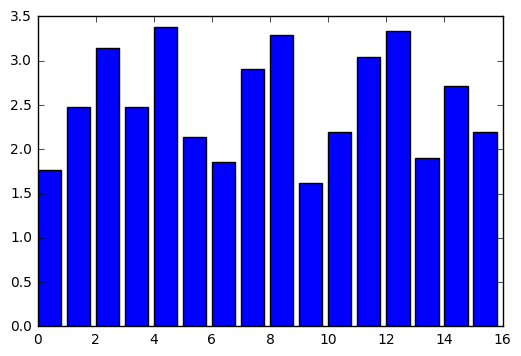

In [25]:
matplotlib.pyplot.bar(X,y)

In [26]:
np.mean(y)

2.5267857142937502

<Container object of 16 artists>

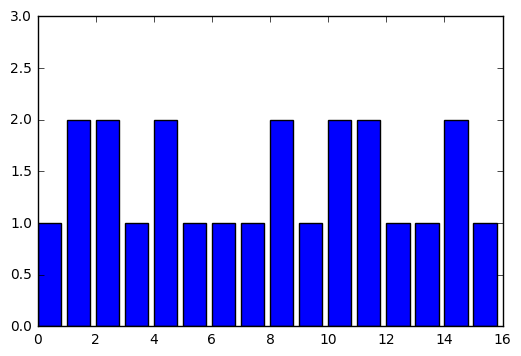

In [40]:
X = range(16)
# res.Wins = res.Wins+1
y = res.Wins.values
matplotlib.pyplot.ylim(0,3)
matplotlib.pyplot.bar(X,y)
